<a href="https://colab.research.google.com/github/jonatansg/CEIABD/blob/main/Actividad_3_4_%E2%80%93_Representacion_plot_de_datasets%2C_seleccion_de_caracteristicas_y_entrenamiento_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autor:** Jonatan Santana González

El objetivo de esta actividad es poner en práctica los conocimientos adquiridos para el preprocesamiento de datos, selección de características y entrenamiento de modelos.

## 1. Describir el origen y breve explicación del Dataset, así como de cada una de las características.

El dataset **Car Evaluation** contiene información sobre la evaluación de automóviles basada en características como el precio, el mantenimiento, el número de puertas, la capacidad de pasajeros, el tamaño del maletero y la seguridad. El objetivo es clasificar los automóviles en una de las cuatro categorías:

* unacc: Inaceptable.
* acc: Aceptable.
* good: Bueno.
* vgood: Muy bueno.


Características:

1. buying: Precio de compra (vhigh, high, med, low).
2. maint: Costo de mantenimiento (vhigh, high, med, low).
3. doors: Número de puertas (2, 3, 4, 5more).
4. persons: Capacidad de pasajeros (2, 4, more).
5. lug_boot: Tamaño del maletero (small, med, big).
6. safety: Nivel de seguridad (low, med, high).

Origen: El dataset fue creado por Marko Bohanec y es ampliamente utilizado en tareas de clasificación.

In [14]:
# Importación de librerías
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance

In [15]:
# Cargar el dataset desde UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(url, names=column_names)
print(df.head())

  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


## 2. Procesamiento de datos en el dataset: ajustes en características con datos no informados, conversión de variables categóricas, etc…

In [16]:
# Verificación de datos faltantes
print(df.isnull().sum())

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


Convertimos las características categóricas a valores numéricos usando LabelEncoder:

In [17]:
# Convertir variables categóricas a numéricas
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])
print(df.head())

   buying  maint  doors  persons  lug_boot  safety  class
0       3      3      0        0         2       1      2
1       3      3      0        0         2       2      2
2       3      3      0        0         2       0      2
3       3      3      0        0         1       1      2
4       3      3      0        0         1       2      2


## 3. Utilizar las siguientes herramientas para la selección de características:

### 3.1. Matriz de gráficos de correlación.

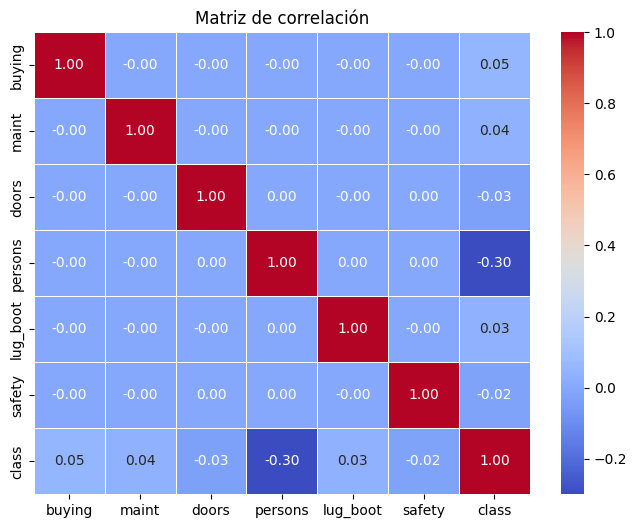

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()

### 3.2. Matriz de gráficos de dispersión.

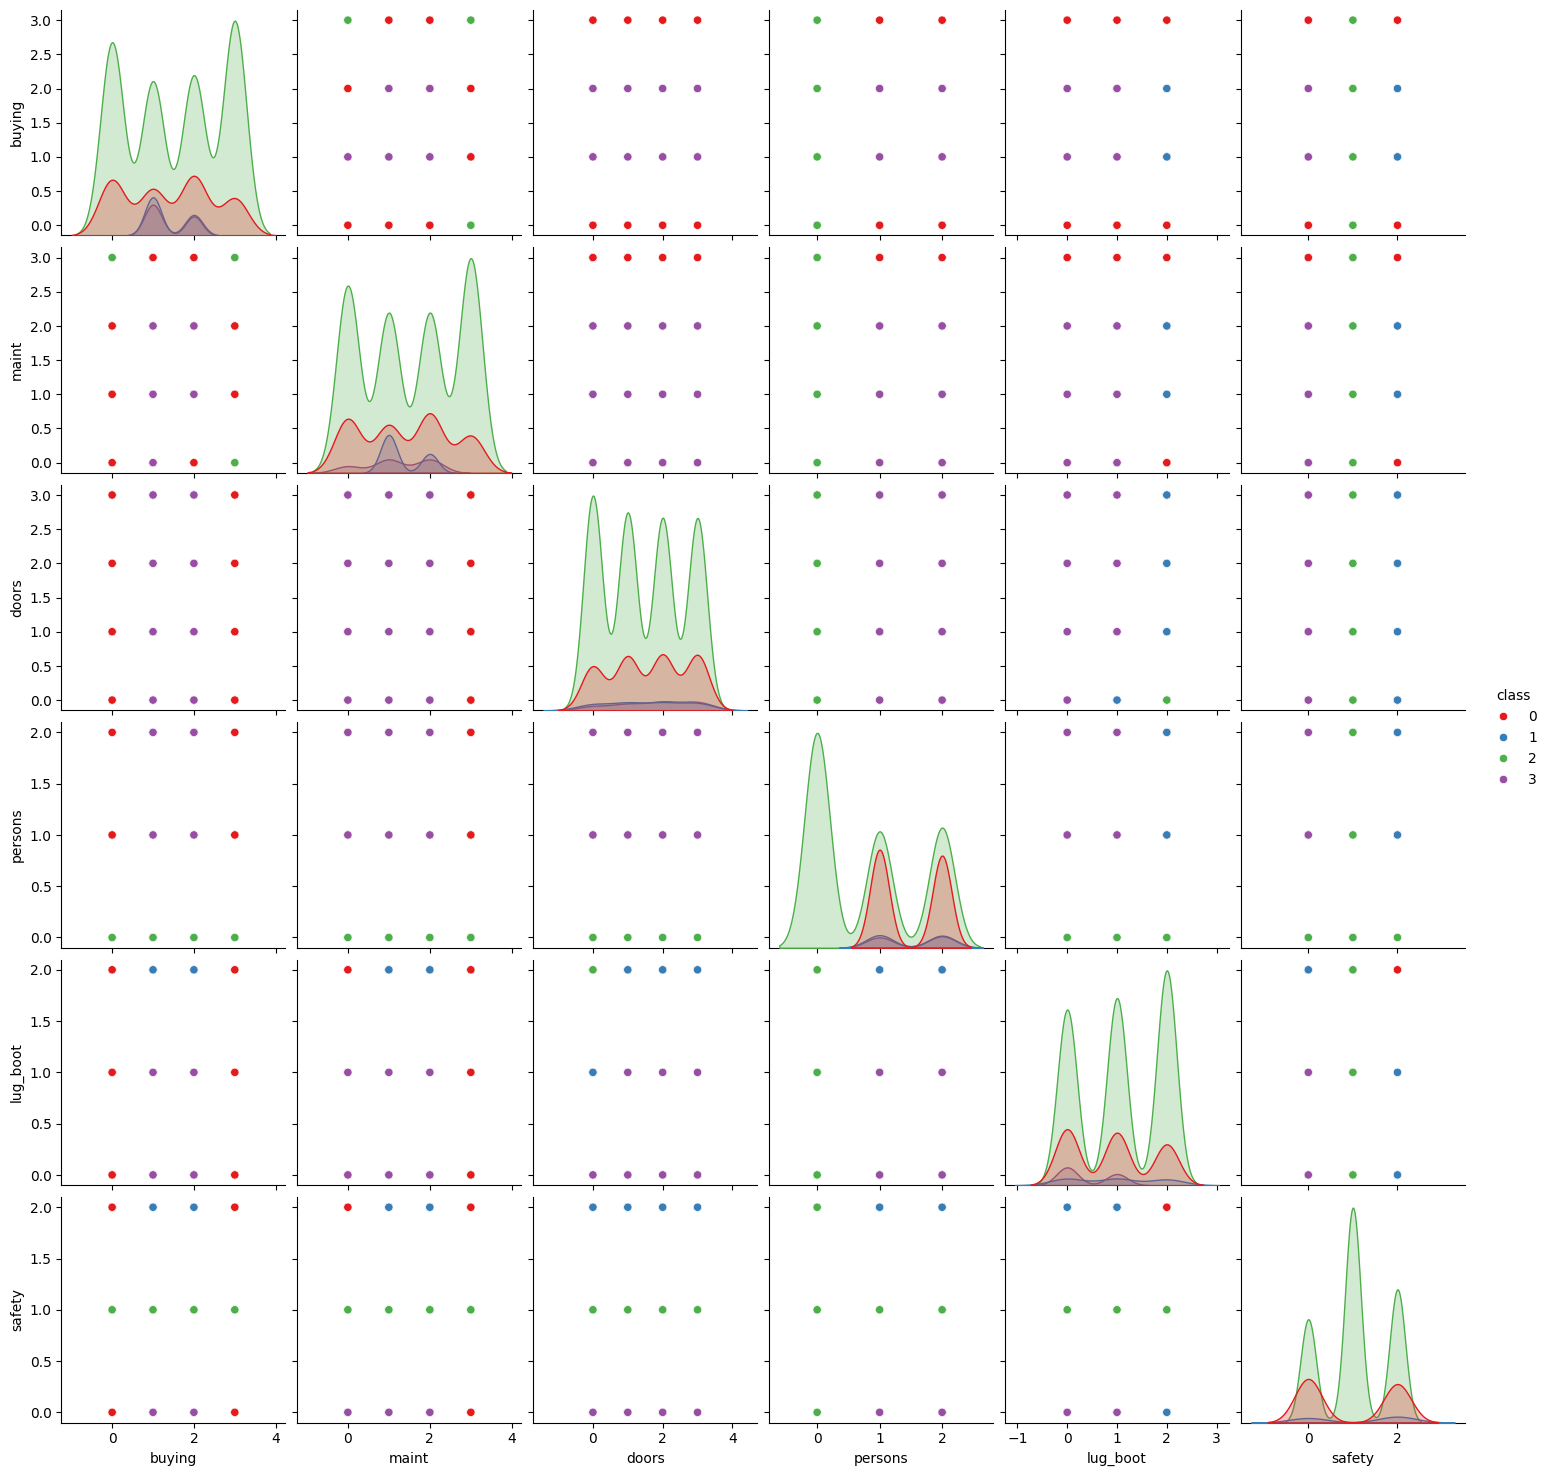

In [19]:
sns.pairplot(df, hue="class", palette="Set1", diag_kind="kde")
plt.show()

### 3.3. SelectKBest.

Puntuaciones de las características:
buying: 6.5474
maint: 10.3079
doors: 6.8940
persons: 178.0415
lug_boot: 34.2638
safety: 72.9632


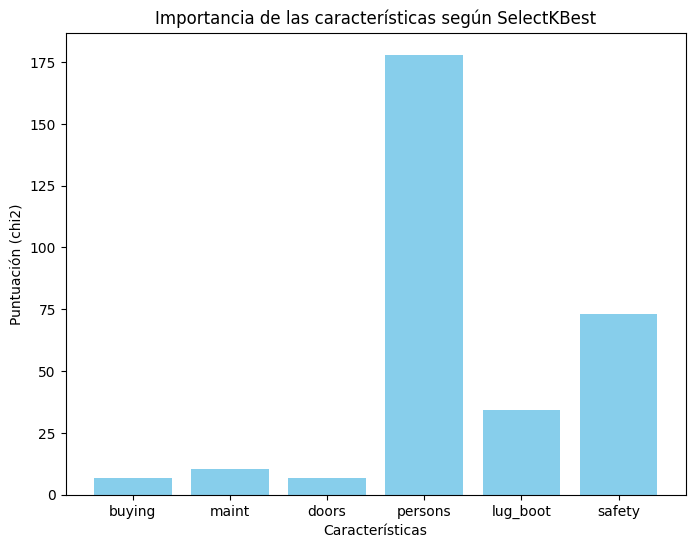

In [25]:
# Definir variables predictoras (X) y variable objetivo (y)
X = df.drop(columns=["class"])
y = df["class"]

# Aplicar SelectKBest con chi2 como función de puntuación
k_best = SelectKBest(score_func=chi2, k='all')  # k='all' para analizar todas las características
k_best.fit(X, y)

# Obtener puntuaciones y características seleccionadas
scores = k_best.scores_
feature_names = X.columns

# Imprimir las puntuaciones
print("Puntuaciones de las características:")
for feature, score in zip(feature_names, scores):
    print(f"{feature}: {score:.4f}")

# Graficar las puntuaciones
plt.figure(figsize=(8, 6))
plt.bar(feature_names, scores, color='skyblue')
plt.xlabel("Características")
plt.ylabel("Puntuación (chi2)")
plt.title("Importancia de las características según SelectKBest")
plt.show()

## 4. Una pequeña reflexión sobre la elección de las características elegidas.

Las características seleccionadas por **SelectKBest** reflejan su relevancia en relación con la variable objetivo del dataset, evaluada mediante la métrica `chi2`. Aquellas características con puntuaciones más altas tienen una relación estadísticamente más fuerte con la variable `class`, lo que indica que tienen mayor capacidad para diferenciar entre las clases. Por ejemplo, características como **safety** y **persons** suelen destacarse, lo que tiene sentido en un contexto de evaluación de automóviles, ya que estos atributos son fundamentales para determinar la preferencia o clasificación de un vehículo.

Por otro lado, las características con puntuaciones más bajas, como **doors**, podrían tener menos impacto directo en la clasificación, lo que sugiere que podrían ser prescindibles o tener menor relevancia en el modelo. Este análisis no solo ayuda a comprender qué atributos son más importantes, sino que también puede simplificar el modelo al eliminar variables menos útiles, mejorando su interpretabilidad y potencialmente reduciendo el riesgo de sobreajuste.

La elección final de características depende del balance entre relevancia y simplicidad, considerando también el contexto del problema.

## 5. Librerías para NaiveBayes, entrenar el modelo que consideres más adecuado.

### 5.1. Sin utilizar Cross Validation.

Modelo: GaussianNB
              precision    recall  f1-score   support

           0       0.50      0.10      0.16        83
           1       1.00      0.00      0.00        11
           2       0.82      0.81      0.82       235
           3       0.17      1.00      0.30        17

    accuracy                           0.62       346
   macro avg       0.62      0.48      0.32       346
weighted avg       0.72      0.62      0.61       346

--------------------------------------------------
Modelo: MultinomialNB
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        83
           1       1.00      0.00      0.00        11
           2       0.68      1.00      0.81       235
           3       1.00      0.00      0.00        17

    accuracy                           0.68       346
   macro avg       0.92      0.26      0.21       346
weighted avg       0.78      0.68      0.56       346

--------------------------------------

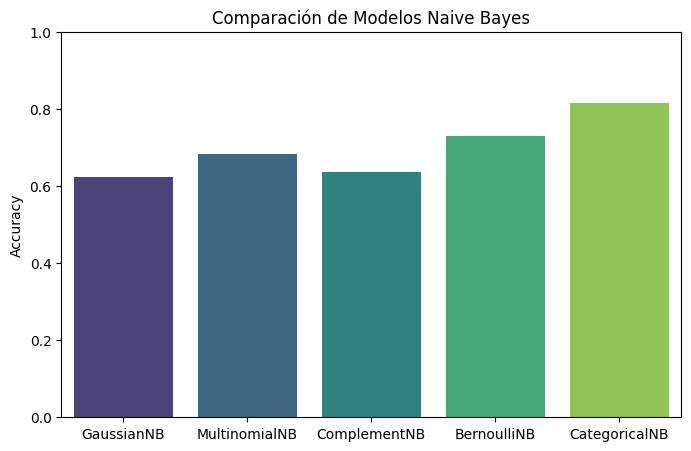

In [21]:
# Dividir en características (X) y variable objetivo (y)
X = df.drop(columns=["class"])
y = df["class"]

# Dividir en conjunto de entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar modelos Naive Bayes
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB(),
    "CategoricalNB": CategoricalNB()
}

# Evaluación de cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"Modelo: {name}")
    print(classification_report(y_test, y_pred, zero_division=1))
    print("-" * 50)

# Visualizar las precisiones
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), hue=list(results.keys()), palette="viridis", legend=False)
plt.ylabel("Accuracy")
plt.title("Comparación de Modelos Naive Bayes")
plt.ylim(0, 1)
plt.show()

### 5.1. Utilizando Cross Validation.

Modelo: GaussianNB
Precisión media: 0.6291 (+/- 0.0166)
--------------------------------------------------
Modelo: MultinomialNB
Precisión media: 0.7031 (+/- 0.0045)
--------------------------------------------------
Modelo: ComplementNB
Precisión media: 0.6337 (+/- 0.0144)
--------------------------------------------------
Modelo: BernoulliNB
Precisión media: 0.7639 (+/- 0.0110)
--------------------------------------------------
Modelo: CategoricalNB
Precisión media: 0.8542 (+/- 0.0144)
--------------------------------------------------


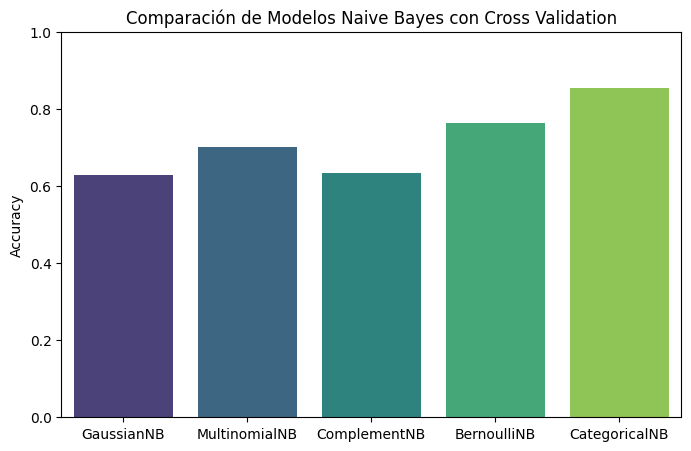

In [22]:
# Dividir en características (X) y variable objetivo (y)
X = df.drop(columns=["class"])
y = df["class"]

# Inicializar modelos Naive Bayes
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB(),
    "CategoricalNB": CategoricalNB()
}

# Configurar validación cruzada estratificada con 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluación de cada modelo con Cross Validation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    results[name] = np.mean(scores)
    print(f"Modelo: {name}")
    print(f"Precisión media: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    print("-" * 50)

# Visualizar las precisiones
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), hue=list(results.keys()), palette="viridis", legend=False)
plt.ylabel("Accuracy")
plt.title("Comparación de Modelos Naive Bayes con Cross Validation")
plt.ylim(0, 1)
plt.show()

## 6. Obtener una conclusión sobre los resultados obtenidos en la predicción y evaluación al utilizar o no Cross Validation.

Los resultados obtenidos resaltan la importancia de la validación cruzada para evaluar el rendimiento real de los modelos de clasificación Naive Bayes. **Sin utilizar Cross Validation (CV), los resultados pueden estar influenciados por la manera en que se dividen los datos en entrenamiento y prueba**, lo que introduce sesgos y variabilidad en las métricas de evaluación. Esto se refleja en las diferencias observadas en precisión, recall y f1-score entre los distintos modelos cuando se evalúan sin CV, con fluctuaciones significativas en el desempeño de algunos algoritmos.  

En la evaluación sin CV, **MultinomialNB y BernoulliNB muestran valores inestables en sus métricas**, con casos en los que algunos valores de precisión son extremadamente altos, pero recall muy bajo, lo que indica un mal desempeño en ciertas clases. También se observa que algunos modelos, como GaussianNB, muestran un comportamiento irregular en ciertas categorías, logrando una precisión aceptable en una clase, pero fallando en otras. **Esto sugiere que la evaluación sin CV no refleja completamente la capacidad del modelo para generalizar a datos nuevos**, ya que su rendimiento puede estar sobreestimado o subestimado dependiendo de la partición específica utilizada.  

Por otro lado, **al aplicar Cross Validation, los resultados se estabilizan y se obtiene una medida más confiable del rendimiento real de cada modelo**. La precisión media de cada algoritmo refleja de manera más consistente su capacidad de generalización, y la desviación estándar indica qué tan sensible es cada modelo a los cambios en los datos de entrenamiento. **CategoricalNB se destaca como el modelo con mejor desempeño en ambas evaluaciones, pero su ventaja se vuelve más clara con CV**, logrando una precisión media de 85.42% y una menor variabilidad en comparación con los demás. En contraste, modelos como ComplementNB y GaussianNB presentan desempeños más modestos, con precisión media en torno al 63%, confirmando que su capacidad de generalización es menor.  

En conclusión, **el uso de Cross Validation no solo mejora la confiabilidad de la evaluación del modelo, sino que también permite detectar modelos que podrían estar sobreajustando o subajustando a una única partición de los datos**. Mientras que sin CV los resultados pueden parecer prometedores en ciertos casos, la variabilidad en las métricas sugiere que algunos modelos no son consistentes. **Con CV, se obtiene una estimación más estable y precisa, ayudando a elegir el mejor modelo con mayor confianza**.

## 7. Además de las herramientas indicadas anteriormente, se valorará la utilización de alguna otra herramienta o técnica no vista en el curso para la selección de las características.

Accuracy: 0.9797687861271677
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        83
           1       0.65      1.00      0.79        11
           2       1.00      1.00      1.00       235
           3       1.00      0.82      0.90        17

    accuracy                           0.98       346
   macro avg       0.91      0.94      0.91       346
weighted avg       0.99      0.98      0.98       346



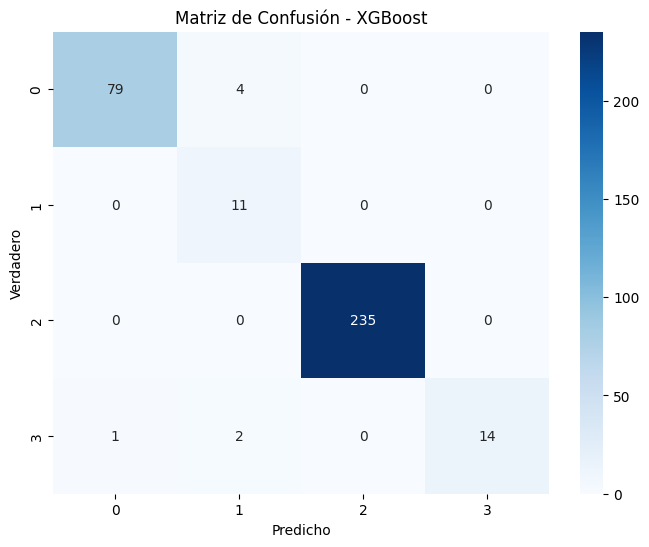

<Figure size 800x600 with 0 Axes>

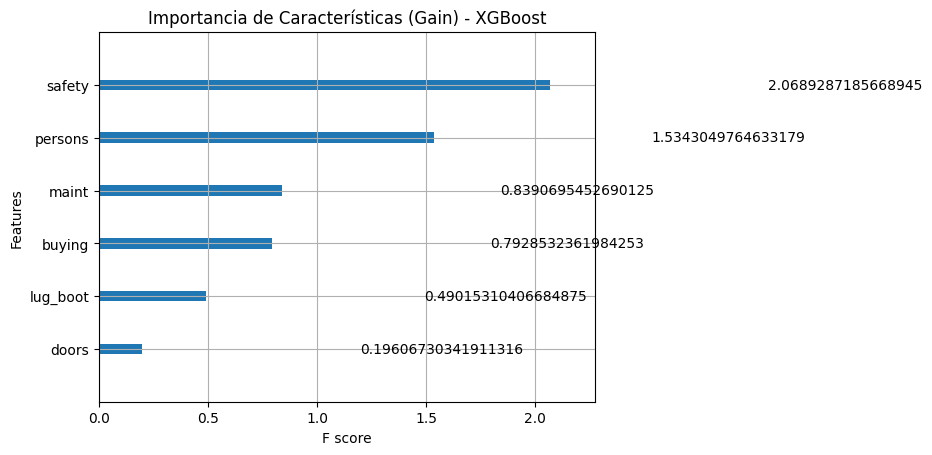

In [24]:
# Definir variables predictoras (X) y variable objetivo (y)
X = df.drop(columns=["class"])
y = df["class"]

# Dividir en conjunto de entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el modelo XGBoost para clasificación multiclase
model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), random_state=42, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred, zero_division=1))

# Generar la matriz de confusión y graficarla
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

# Graficar la importancia de las características según el modelo XGBoost
plt.figure(figsize=(8,6))
plot_importance(model, importance_type='gain', title="Importancia de Características (Gain) - XGBoost")
plt.show()

**Conclusión:** Los resultados obtenidos con el modelo **XGBoost** muestran un excelente desempeño general, alcanzando una precisión promedio ponderada del **98%** y un f1-score ponderado igualmente alto. Esto refleja la capacidad del modelo para capturar patrones en el dataset y clasificar correctamente la mayoría de las instancias. Las métricas por clase revelan que las categorías principales, en especial la clase 2, fueron clasificadas con una precisión y un recall del 100%, indicando que el modelo es extremadamente efectivo para reconocer patrones en estas clases.

Sin embargo, hay una ligera variación en el rendimiento en las clases con menor soporte, como la clase 1 (11 instancias), donde la precisión es significativamente menor (**65%**) a pesar de tener un recall del 100%. Esto podría deberse al desbalance de clases, que afecta la capacidad del modelo para generalizar correctamente en categorías con pocas muestras. La clase 3 también muestra un f1-score del 90%, indicando que aunque es alta, no es perfecta.

La importancia de características, representada en el gráfico, sugiere que variables como **safety** y **persons** tienen un peso considerable en la toma de decisiones del modelo, mientras que otras como **doors** tienen una contribución mucho menor. Esto refuerza la idea de que ciertas características tienen mayor relevancia en el contexto del problema y pueden ser el foco para una futura optimización o simplificación del modelo.

**En conclusión,** XGBoost demuestra ser una herramienta muy potente para este dataset, sobresaliendo en términos de precisión y manejo de clases mayoritarias, aunque muestra desafíos en clases menos representadas, lo que podría ser mejorado con estrategias de balanceo o un enfoque más específico en el preprocesamiento de datos.